## SETUP

In [26]:
# HOME
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
# use seaborn plotting defaults
import seaborn as sns; sns.set()

# get the code
import sys
sys.path.append('../codeCNV')
from plot import plot_snp, plot_2d, plot_3d

home = '/Users/mahtin'
# home = '/Users/martinscience'
# standard paths
testdata = os.path.join(home,"Dropbox/Icke/Work/somVar/testdata")
static_path = os.path.join(home, "Dropbox/Icke/Work/static")
cluster_path = os.path.join(home, "mount")
tooldata = os.path.join(home, "Dropbox/Icke/Work/somVar/tooldata")

# load the config
# edit config directly in yaml file
import yaml
config_file = '../config/config_devel.yaml'
def get_config(config_file):
        with open(config_file) as file:
        # The FullLoader parameter handles the conversion from YAML
        # scalar values to Python the dictionary format
            config = yaml.load(file, Loader=yaml.FullLoader)['CNV']['cluster']
        return config
config = get_config(config_file)

cnvdata = os.path.join(tooldata, "myCNVdata")
output_path = os.path.join(cnvdata, "output")

# the path to the input data
cnv_path = os.path.join(cnvdata, "cnv")
cnvPON_path = cnv_path = os.path.join(cnvdata, "chromCov")
cnv_path = os.path.join(cluster_path, "scratch/develop/PONcoverage/cnv")
cnvPON_path = os.path.join(cluster_path, "scratch/develop/PONcoverage/chromCov")

In [27]:
cnvPON_path

'/Users/mahtin/mount/scratch/develop/PONcoverage/chromCov'

## get the coverage and SNP data

In [28]:
sample = "01_A"
snp_df = pd.read_csv(os.path.join(output_path, f'rollingCNV/{sample}.snp.csv'), sep='\t').dropna()

### vizualize

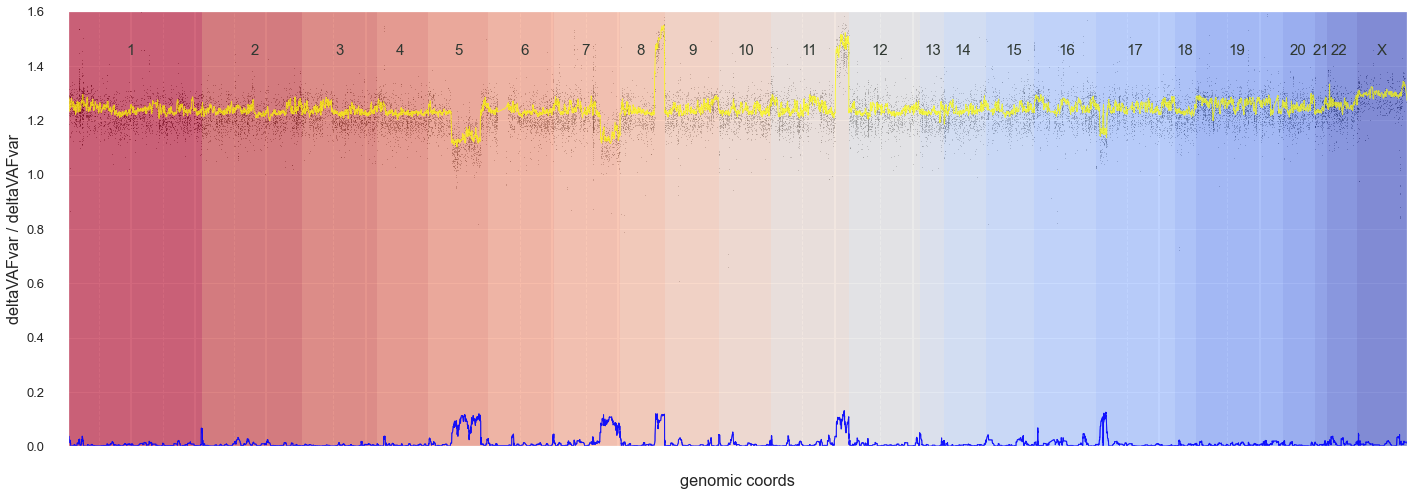

In [82]:
log2 = dict(
        title='log2ratio',
        plot_type='scatter',   # ['line', 'scatter']
        data='log2ratio',
        plot_args=dict(
            linewidth=0.3,
            color='black',
            s=0.2,
            alpha=.7
        )
    )

log2mean = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )
vaf = dict(
        title='VAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='VAF',
        plot_args=dict(
            linewidth=0.5,
            color='blue',
            s=5,
            alpha=1
        ))


absvafmean = dict(
        title='deltaVAFvar',
        plot_type='line',   # ['line', 'scatter']
        data='deltaVAFvar',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )
deltavafvar = dict(
        title='deltaVAFvar',
        plot_type='line',   # ['line', 'scatter']
        data='deltaVAFvar',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )

fig_params = dict(
    figsize=(24,8),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(0,1),
    cov_offset=.1,  # how much log2ratio=0 is shifted above SNP-data
    cov_height=.5,
    label_size=13
)
chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
r1 = 'chr17:3Mb-9Mb'
%matplotlib inline
_ = plot_snp(snp_df, snp_plots=[absvafmean, deltavafvar], cov_plots=[log2, log2mean], chroms='all', region='', **fig_params)

## finding the weird traces (like in chr7)

<IPython.core.display.Javascript object>


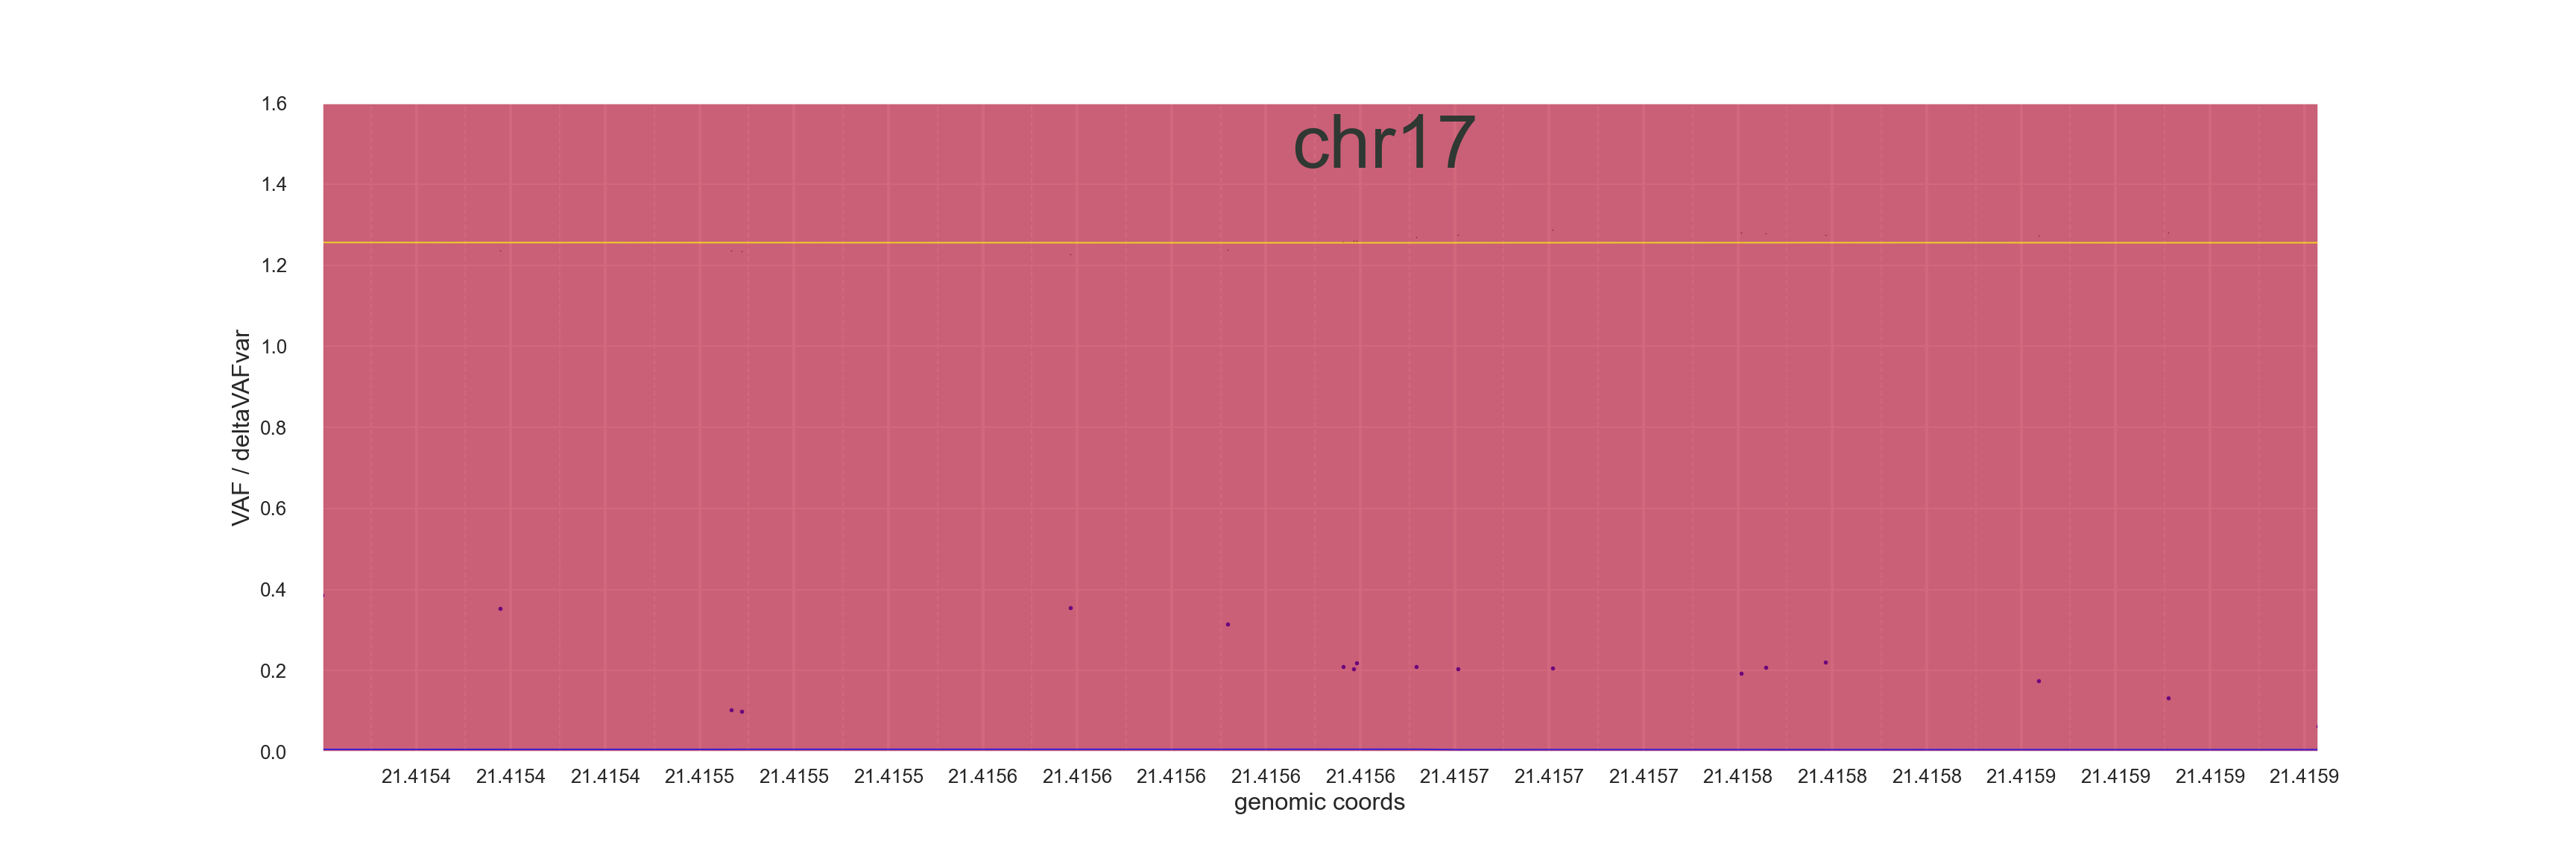

In [30]:
tchroms = ['chr1', 'chr7', 'chr11', 'chr13', 'chr16', 'chr17', 'chr19', 'chr20', 'chr22', 'chrX']
_ = plot_snp(snp_df, snp_plots=[vaf, deltavafvar], cov_plots=[log2, log2mean], chroms=tchroms, region='chr17:21415000-21416000', **fig_params)

In [31]:
def region_query(region):
    '''
    function 
    '''

    def convert(pos):
        if pos.endswith('Mb'):
            pos = int(float(pos.replace('Mb', '')) * 1e6)
        elif pos.endswith('kb'):
            pos = int(float(pos.replace('kb', '')) * 1000)
        else:
            pos = int(pos)
        return pos

    split = region.split(':')
    chrom = split[0]

    # if start and are used
    if len(split) > 1 and '-' in split[1]:
        se = split[1].split('-')
        start = convert(se[0])
        end = convert(se[1])
    else:
        start = 0
        end = 1e10
    return f'(Chr == "{chrom}" and {start} < Pos < {end})'

def r_query(df, region_list):
    '''
    returns an or-combined pandas query for the regions in the list
    '''
    
    r_query = " or ".join([region_query(chrom) for chrom in [chr1, chr7, chr17]])
    return df.query(r_query)

### make bad_df from suspicious regions

In [32]:
chr1 = 'chr1:12790000-12800000'
chr7 = 'chr7:101034000-101036000'
chr17 = 'chr17:21415000-21416000'

bad_df = r_query(snp_df, [chr1, chr7, chr17])

### look where the bad stuff lies

<IPython.core.display.Javascript object>


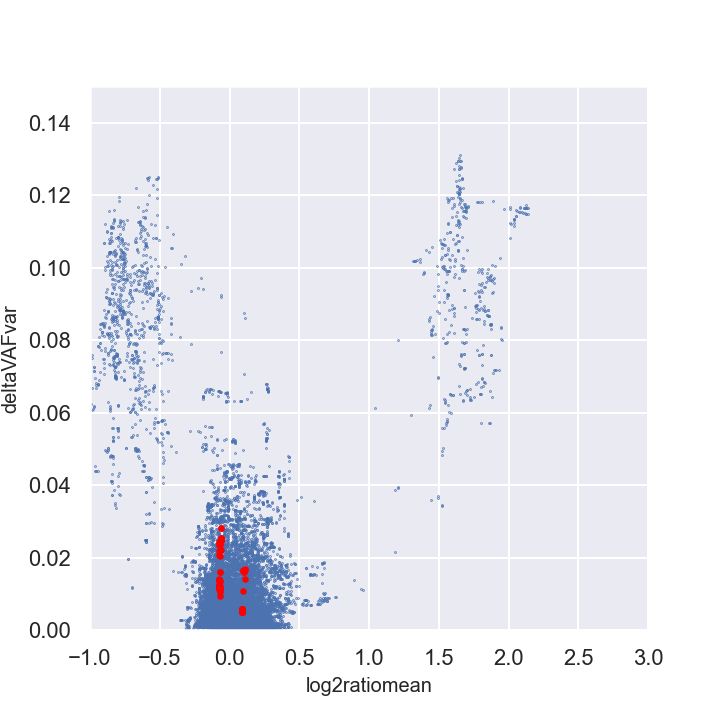

In [33]:
xcol = 'log2ratiomean'
ycol = 'deltaVAFvar'
plot_2d(snp_df, df2=bad_df, xcol=xcol, ycol=ycol)

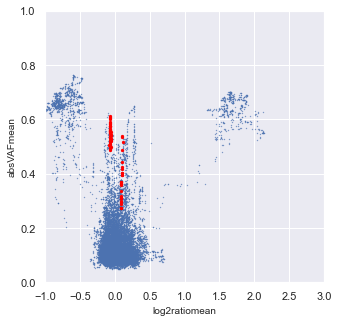

In [58]:
%matplotlib inline
plot_2d(snp_df, 'log2ratiomean', 'absVAFmean', df2=bad_df)

<IPython.core.display.Javascript object>


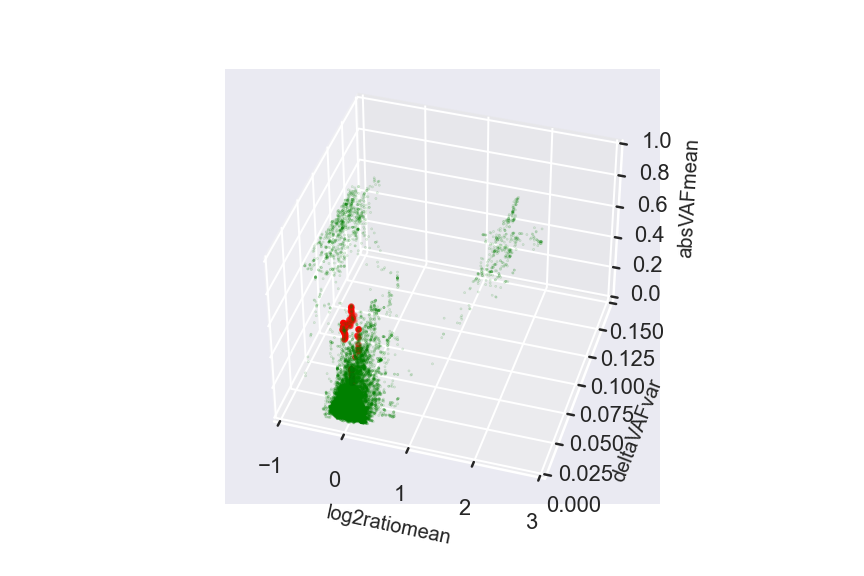

In [86]:
colx = 'log2ratiomean'
coly = 'deltaVAFvar'
colz = 'absVAFmean'

%matplotlib notebook
plot_3d(snp_df, df2=bad_df, xcol=colx, ycol=coly, zcol=colz, figsize=(15,15))

## clustering strategy

* unsupervised training
    + #### filter out below-average in log2ratio or deltaVAFvar
    + #### creating a visualisation for clusters on genomic data
    + #### clean filtered df with KDE
    + #### cluster filtered df with GMM
    + #### cluster background with low-stringency filter
* supervised clustering of full data 

### filter out below average
+ make a relative cutoff for all values of special data columns below a certain threshold

In [78]:
def filter_threshold(snp_df, threshs={}):
    '''
    takes threshold dict {'log2ratio': [0.5, True], 'deltaVAFvar': [0.075, True]}
    and returns 
    '''
    df = snp_df.copy()
    # mask is boolean series stating if snp is background
    df['cnv'] = False
    mask = df['cnv']
    for col in threshs.keys():      
        thresh = threshs[col][0] if threshs[col][1] else threshs[col][0] * df[col].max()
        col_mask = np.abs(df[col]) > thresh
        mask = mask | col_mask
    df['cnv'] = mask.astype(int)
    return df


def split_df_by_thresholds(df, thresholds={}):
    
    # get the stringent from the threshold dict
    cnv_thresholds = {}
    for col in thresholds.keys():
        cnv_thresholds[col] = thresholds[col][::2]
    filter_df = filter_threshold(snp_df, threshs=cnv_thresholds).query('cnv == 1')
    
    # get the center mass
    center_thresholds = {}
    for col in thresholds.keys():
        center_thresholds[col] = thresholds[col][1:]
    center_df = filter_threshold(snp_df, threshs=center_thresholds).query('cnv == 0')

    return filter_df, center_df

<IPython.core.display.Javascript object>


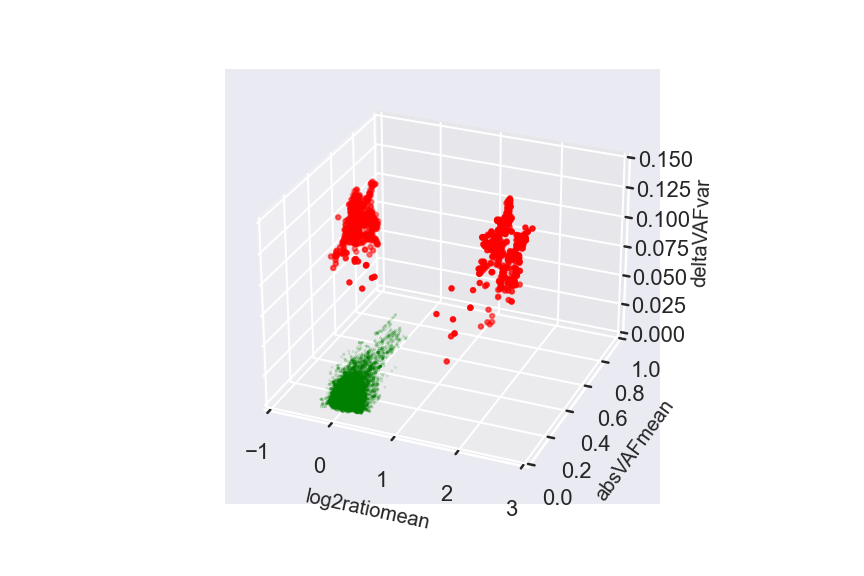

In [97]:
config = get_config(config_file)
filter_df, center_df = split_df_by_thresholds(snp_df.query('Chr != "chrX"'), thresholds=config['thresholds'])
plot_3d(center_df, df2=filter_df, xcol='log2ratiomean', ycol='absVAFmean', zcol='deltaVAFvar');

### KDE for cleaning up the filter_df

In [107]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

# get the matrix
select_cols = ['log2ratiomean', 'absVAFmean', 'deltaVAFvar']

def clean_KDE(filter_df, cols, cleanup_density=0.25):
    # prepare the matrix
    X = filter_df[cols]
    # gridsearch the best density params
    bandwidths = np.logspace(-2, 0, 25)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=7).fit(X)
    # fit best model to data
    kde = grid.best_estimator_
    _ = kde.fit(X)
    # get the densities for the samples
    filter_df['density'] = kde.score_samples(X)
    # determine the threshold
    thresh = filter_df['density'].min() + (filter_df['density'].max() -  filter_df['density'].min()) * cleanup_density
    return filter_df.query('density < @thresh')

<IPython.core.display.Javascript object>


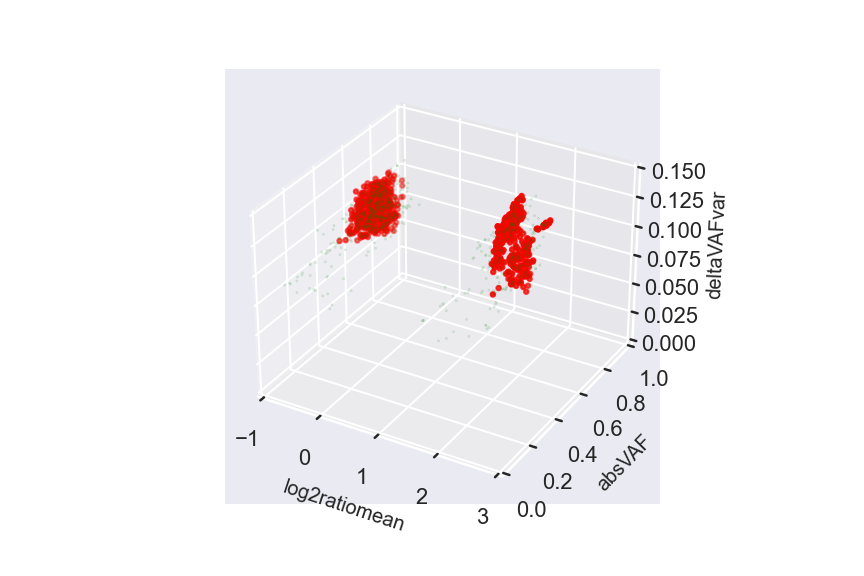

In [108]:
clean_df = clean_KDE(filter_df, select_cols, 0.3)
plot_3d(filter_df, df2=cleaned_df, xcol='log2ratiomean', ycol='absVAF', zcol='deltaVAFvar');

## fit this cleaned set with GMM

In [ ]:
select_cols = ['log2ratiomean', 'absVAF', 'deltaVAFvar']
X = cleaned_df[select_cols]

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score as ssc
labels = GMM(n_components=2, covariance_type='diag', n_init=20).fit_predict(X)
%matplotlib inline
fig, ax = plt.subplots()

xcol = 'log2ratiomean'
ycol = 'deltaVAFvar'
_ = ax.scatter(X[xcol], X[ycol], c=labels, s=1, cmap='viridis')
_ = ax.set_xlabel(xcol, fontsize=10)
_ = ax.set_ylabel(ycol, fontsize=10)

print('Silhouette score: ', ssc(X, labels, metric='euclidean'))

### find the optimal components

In [ ]:
n_components = np.arange(2, 10)
models = [GMM(n, covariance_type='full', n_init=20).fit(X)
          for n in n_components]
fig, ax = plt.subplots()
_ = ax.plot(n_components, [m.bic(X) for m in models], label='BIC')
_ = ax.plot(n_components, [m.aic(X) for m in models], label='AIC')
_ = ax.plot(n_components, [ssc(X, m.predict(X), metric='euclidean') * -5000 for m in models], label='SilScore')
_ = ax.legend(loc='best')
_ = ax.set_xlabel('n_components');

In [ ]:
from sklearn.cluster import DBSCAN
select_cols = ['log2ratiomean', 'absVAF', 'deltaVAFvar']
X = filter_df[select_cols]
rows = X.shape[0]
ep=0.2
ms = int(rows/20)

labels = DBSCAN(eps=ep, min_samples=ms).fit_predict(X)
plt.scatter(X['log2ratiomean'], X['absVAF'], c=labels, s=1, cmap='viridis')
np.unique(labels)

## DBSCAN for finding the clusters and reducing noise

In [ ]:
from sklearn.cluster import DBSCAN

# get the matrix
allcols = ['log2ratiomean', 'VAF', 'absVAF', 'deltaVAFstd', 'deltaVAFvar', 'VAFstd']
select_cols = ['log2ratiomean', 'absVAF', 'deltaVAFvar']
X = filter_df[select_cols]
rows = X.shape[0]

ep=0.1
ms = int(rows/20)

labels = DBSCAN(eps=ep, min_samples=ms).fit_predict(X)
plt.scatter(X['log2ratiomean'], X['absVAF'], c=labels, s=1, cmap='viridis')
cluster, counts = np.unique(labels, return_counts=True)
cluster_count = len(cluster[cluster != -1])
cluster_size = counts[np.argmax(counts)]
cluster_id = cluster[np.argmax(counts)]
print(f"ep:{round(ep,2)}|min_samples:{ms}>> {cluster_count} clusters | cluster{cluster_id}: {cluster_size}")

In [ ]:
def fit_DBSCAN(X, max_cluster=1, eps=np.logspace(-1,1,10), sample_fracs=np.logspace(-3,-1,10)):
    max_counts = 0
    for sample_frac in sample_fracs:
        for ep in eps:
            # sample_fraction up to all samples if wanted
            ms = min(X.shape[0], int(X.shape[0] * sample_frac))
            model = DBSCAN(eps=ep, min_samples=ms)
            labels = model.fit_predict(X)
            cluster, counts = np.unique(labels, return_counts=True)
            # get the number of clusters 
            cluster_count = len(cluster[cluster != -1])
            # get the size of cluster 0
            #! maybe use better with largest cluster
            cluster_size = counts[np.argmax(counts)]
            if cluster_count:
                if cluster_size > max_counts:
                    best_model = model
                    print(f"Best model: ep:{round(ep,2)}|min_samples:{ms}>> {cluster_count} clusters | cluster0: {cluster_size}")
                    if (cluster_count <= max_cluster):
                        best_limit_model = model      
                        print(f"BEST model: ep:{round(ep,2)}|min_samples:{ms}>> {cluster_count} clusters | cluster0: {cluster_size}")
    return best_model, best_limit_model

In [ ]:
best_model, best_limit_model = fit_DBSCAN(X, max_cluster=3)

In [ ]:
labels = best_model.fit_predict(X)
plt.scatter(X['log2ratiomean'], X['absVAF'], c=labels, s=1, cmap='viridis')

### GMM

In [ ]:
# get the matrix from the df
allcols = ['log2ratiomean', 'VAF', 'absVAF', 'deltaVAFstd', 'deltaVAFvar', 'VAFstd']
select_cols = ['log2ratiomean', 'absVAF', 'deltaVAFvar']
X = filter_df[select_cols]
rows = X.shape[0]
X.shape

+ #### GMM clustering runs best for fitting the center mass
    * clusters vary depending on init clusters

In [ ]:
from sklearn.mixture import GaussianMixture as GMM

choice = range(5)
fig, axes = plt.subplots(1, len(choice), figsize=(20,5))
for i, components in enumerate(choice):
    gmm = GMM(n_components=3, covariance_type='diag', n_init=20)
    labels = gmm.fit_predict(X)
    _, counts = np.unique(labels, return_counts=True)
    print(np.max(counts))
    _ = axes[i].scatter(X['log2ratiomean'], X['absVAF'], c=labels, s=1)
    # print(f'{components} components - AIC:', gmm.aic(X))
    # print(f'{components} components - BIC:', gmm.bic(X))

In [ ]:
from sklearn.mixture import GaussianMixture as GMM

def get_centers(df, runs=25, comps=3, exclude_X=True, cols=['log2ratiomean', 'VAF']):
    '''
    use GMM to identify the center cluster and get the means from that
    because GMM occasionally does not identify the center cluster,
    I let the GMM proceed several times and minimize the center cluster
    next, the center cluster can be identified as the maximum center
    '''
    VAFmin, VAFmax = VAF_limits
    # fit the centers to the data 
    if exclude_X:
        df = df.query('Chr != "chrX"')     
    X = df[cols]

    gmm = GMM(n_components=comps, covariance_type='diag', n_init=runs).fit(X)
    labels = gmm.predict(X)
    # get the size of the 
    cluster_id, counts = np.unique(labels, return_counts=True)
    
    print(cluster_id, counts, gmm.means_)
    maxcount = np.max(counts)
    centers = pd.DataFrame(gmm.means_, columns=['log2ratio', 'VAF'])
    # get mean_cov and meanVAF from largest cluster
    meanCov, meanVAF = centers.loc[np.argmax(counts)]
    size = maxcount
            
    print(f'GMM using {runs} inits: center size {size} meanVAF = {round(meanVAF, 2)} meanCov={round(meanCov, 2)}')
    
    return meanCov, meanVAF, centers

### DBSCAN

In [ ]:
24000 / 200

### loading labels back into df

In [ ]:
snp_df['dbscan'] = labels
snp_df

In [ ]:
snp_df.to_csv(os.path.join(output_path, f'cluster/{sample}.dbscan.csv'), sep='\t', index=False)

In [ ]:
counts[np.argmax(counts)]

+ #### DBSCAN seems to be best fitted for removing the center mass as the spread is hard to guess
    * perform a grid search on eps and min_samples to find the maximum center mass with just one cluster
    * better!: perform this grid search on multi-dimensional data

In [ ]:
np.unique(labels)

In [ ]:
labels = best_limit_model.fit_predict(X)
plt.scatter(X['log2ratiomean'], X['absVAF'], c=labels, s=1, cmap='viridis')

In [ ]:
np.unique(labels)

In [ ]:
snp_df['DBID'] = labels
snp_df

In [ ]:
cnv_df = snp_df.query('DBID > 0')
cnv_df

In [ ]:
fig_params = dict(
    figsize=(24,8),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(0,1),
    cov_offset=.1,  # how much log2ratio=0 is shifted above SNP-data
    cov_height=.5,
    label_size=13
)

log2 = dict(
        title='log2ratio',
        plot_type='scatter',   # ['line', 'scatter']
        data='log2ratio',
        plot_args=dict(
            linewidth=0.3,
            color='black',
            s=0.2,
            alpha=.7
        )
    )

log2mean = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

absvaf = dict(
        title='absVAF',
        plot_type='scatter',  # ['line', 'scatter']
        data='absVAF',
        cluster={'DBID', 'blue'}
        plot_args=dict(
            s=1,
            c=snp_df.query('Chr in @chroms')['DBID'],
            alpha=.7
        )
    )

chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
r1 = 'chr17:3Mb-9Mb'

fig, ax, df, chrom_df = plot_snp(snp_df, snp_plots=[absvaf], cov_plots=[log2, log2mean], chroms=chroms, region='', **fig_params)

+ increasing n_init to 20 does the job:

In [ ]:
choice = range(5)
fig, axes = plt.subplots(1, len(choice), figsize=(20,5))
for i, components in enumerate(choice):
    gmm = GMM(n_components=3, covariance_type='diag', n_init=25)
    labels = gmm.fit_predict(X)
    _, counts = np.unique(labels, return_counts=True)
    print(np.max(counts))
    _ = axes[i].scatter(X['log2ratiomean'], X['VAF'], c=labels, s=1)
    # print(f'{components} components - AIC:', gmm.aic(X))
    # print(f'{components} components - BIC:', gmm.bic(X))